In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import pickle
import cmcrameri.cm as cmc

In [2]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [3]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [4]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [5]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [list(np.arange(0, 25.6, 0.1))]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append(list(np.arange(0, 25.6, 0.1)))
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                #time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(10**float(split[1]))
            else:
                stf_count += 1

    # time = np.arange(0, 25.6, 0.1)
    # time = np.array(time)
    return momentrate, time

In [6]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    #print(momentrate)
    return momentrate[0], time

In [7]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [8]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [9]:
def find_end_stf(momentrate, time, dataset = ''):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]

    if dataset == 'sigloch':
        start = np.where(momentrate > 0.05 * max(momentrate))[0][0]
    else:
        start = min(not_zero)
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [10]:
to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

columns_to_save = ['event', 'dataset', 'mag', 'interp_momentrate']
df_interp = pd.DataFrame(columns = columns_to_save)
max_len = 0
for i, row in combined.iterrows():
	# if i < 360:
	# 	continue

	#fig, axs = plt.subplots(2, 1, figsize=(10, 10))


	for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):

		if dataset == 'scardec_moy' or dataset == 'scardec_opt':
			name = row[dataset[:-4]]
		else:
			name = row[dataset]

		if name == '0' or name == 0:
			continue

		if dataset == 'scardec_moy':
			momentrate, time = get_stf(name, 'fctmoy')
		elif dataset == 'scardec_opt':
			momentrate, time = get_stf(name, 'fctopt')
		else:
			momentrate, time = get_stf(name)

		if dataset != 'sigloch':
			momentrate_list = [momentrate]
			time_list = [time]
		else:
			momentrate_list = momentrate
			time_list = time

		count = 0
		for momentrate, time in zip(momentrate_list, time_list):
			if time[0] == time[1]:
				time = time[1:]

			if dataset != 'sigloch':
				save_key = row.event
				dataset_name = dataset
			else:
				dataset_name = dataset + '_' + str(count)
				save_key = row.event + '_' + str(count)

			if save_key in to_ignore:
				continue
			#print(time[0:10])
			
			momentrate = np.array(momentrate)

			time = np.array(time)
			detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time, dataset)
			time = time[detected_start:detected_end] # shift to start STF at zero
			time = time - time[0]
			momentrate = momentrate[detected_start:detected_end]
			max_len = max(max_len, len(momentrate))
			norm_momentrate = momentrate #/ max(momentrate)
			norm_time = time #/ max(time)
			#axs[0].plot(norm_time, norm_momentrate)

			interp_momentrate_stf = np.interp(np.linspace(0, max(time), int(max(time)*100)), norm_time, norm_momentrate)
			interp_momentrate = np.zeros(20000)
			if max(time) < 200:
				interp_momentrate[0:int(max(time)*100)] = interp_momentrate_stf
			else:
				interp_momentrate = interp_momentrate_stf[0:20000]
			interp_momentrate[interp_momentrate < 0] = 0

			#axs[1].plot(np.linspace(0, 1, 100), interp_momentrate)

			df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, interp_momentrate]], columns = columns_to_save)], ignore_index = True)
			count += 1
	#plt.show()
	#plt.close()
	# if i > 361:
	# 	break
	# 	break


/tmp/ipykernel_1171197/1654113292.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, interp_momentrate]], columns = columns_to_save)], ignore_index = True)


In [11]:
df_interp_all = df_interp.copy()

In [16]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))

for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	subset = filtered.interp_momentrate.values
	print(f'$M{b}$--${b+interval}$: $N={len(subset)}$; ')

$M5.0$--$5.25$: $N=5$; 
$M5.25$--$5.5$: $N=33$; 
$M5.5$--$5.75$: $N=204$; 
$M5.75$--$6.0$: $N=2977$; 
$M6.0$--$6.25$: $N=3029$; 
$M6.25$--$6.5$: $N=2129$; 
$M6.5$--$6.75$: $N=1227$; 
$M6.75$--$7.0$: $N=824$; 
$M7.0$--$7.25$: $N=434$; 
$M7.25$--$7.5$: $N=242$; 
$M7.5$--$7.75$: $N=175$; 
$M7.75$--$8.0$: $N=111$; 
$M8.0$--$8.25$: $N=48$; 
$M8.25$--$8.5$: $N=24$; 
$M8.5$--$8.75$: $N=3$; 
$M8.75$--$9.0$: $N=3$; 
$M9.0$--$9.25$: $N=3$; 


5.0 0.0122 5
5.2 0.009 33
5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434


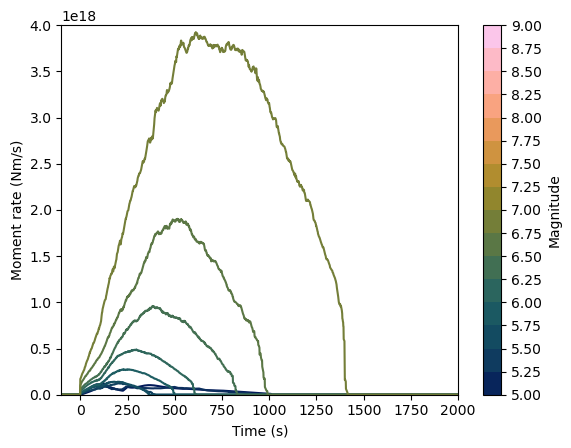

In [38]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0

fig, ax = plt.subplots()  # Create a figure and an axis

for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if b > 7:
		continue
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		y_med = np.nanmedian(list(subset), axis = 0)
		x = np.arange(0, 20000, 1)
		y = np.zeros(21000)
		y[1000:] = y_med
		x = np.arange(-1000, 20000, 1)
		plt.plot(np.arange(-1000, 20000, 1), y, label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue


sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


# plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



plt.xlim(-100, 2000)
plt.ylim(0, 4E18)
# plt.yscale('log')
#plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_M5_to_7.png', bbox_inches = 'tight', dpi = 300)



5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434


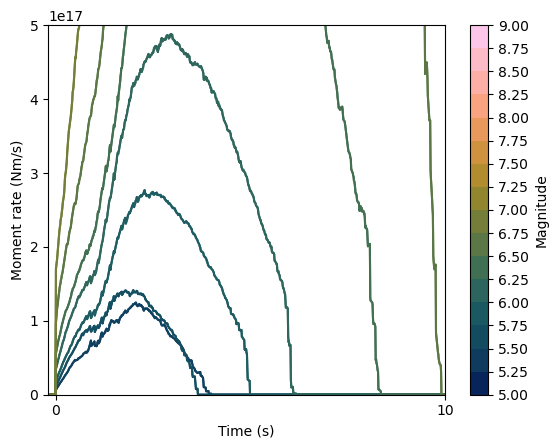

In [42]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0

fig, ax = plt.subplots()  # Create a figure and an axis
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if b < 5.5 or b > 7:
		continue
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		y_med = np.nanmedian(list(subset), axis = 0)
		x = np.arange(0, 20000, 1)
		y = np.zeros(21000)
		y[1000:] = y_med
		x = np.arange(-1000, 20000, 1)
		plt.plot(np.arange(-1000, 20000, 1), y, label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)

		plt.plot(x, y, label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



plt.xlim(-20, 1000)
plt.ylim(0, 5E17)
# plt.yscale('log')
#plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_M5_to_7_zooom.png', bbox_inches = 'tight', dpi = 300)



5.0 0.0122 5
5.2 0.009 33
5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3
8.8 0.4702 3
9.0 0.6918 3


/tmp/ipykernel_618767/835112762.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)


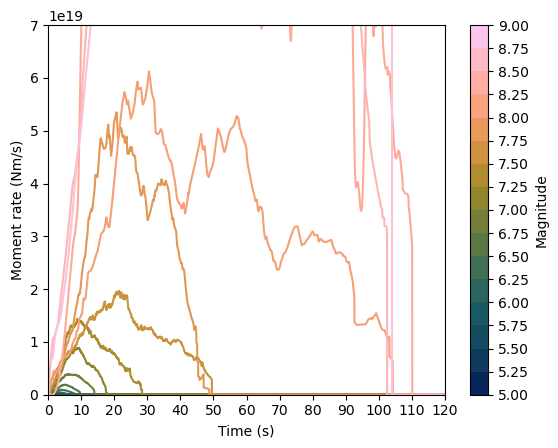

In [ ]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



plt.xlim(0, 12000)
plt.ylim(0, 7E19)
#plt.legend()
# plt.yscale('log')


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_mags.png', bbox_inches = 'tight', dpi = 300)



In [77]:
max(boundaries)

9.0

5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.4702 9


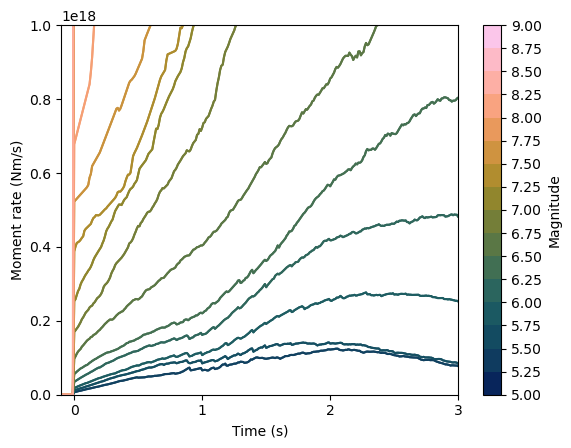

In [43]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0

fig, ax = plt.subplots()  # Create a figure and an axis
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	UL = b+interval
	if b < 5.5:
		continue
	if b > 8.5:
		continue
	if b == 8.5:
		filtered = bigger_than
	else:
		filtered = bigger_than[bigger_than.mag < UL]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	number_of_events = filtered.event.nunique()
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		y_med = np.nanmedian(list(subset), axis = 0)
		x = np.arange(0, 20000, 1)
		y = np.zeros(21000)
		y[1000:] = y_med
		x = np.arange(-1000, 20000, 1)
		plt.plot(np.arange(-1000, 20000, 1), y, label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)

		plt.plot(x, y, label = f'{b:.2f}---{UL:.2f} (N STFs={len(subset)}, Events = {number_of_events})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))



plt.xlim(-10, 300)
plt.ylim(0, 1E18)
# plt.yscale('log')
#plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_mags_zoom.png', bbox_inches = 'tight', dpi = 300)



5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24


/tmp/ipykernel_618767/3671595564.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)


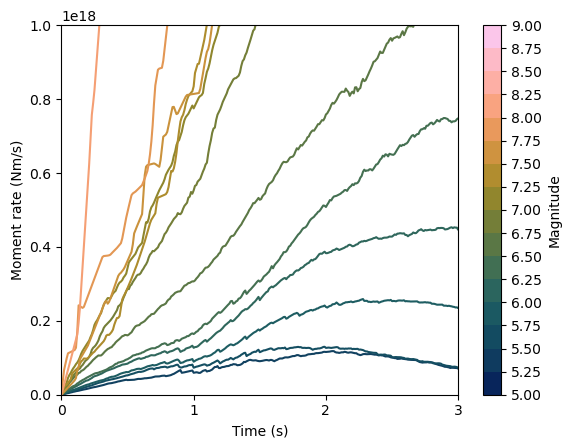

In [79]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	UL = b+interval
	if b >= 8.5 or b < 5.5:
		continue
	if b == 8.5:
		filtered = bigger_than
		
	else:
		filtered = bigger_than[bigger_than.mag < UL]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	number_of_events = filtered.event.nunique()
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0)-np.nanmedian(list(subset), axis = 0)[0], label = f'{b:.2f}---{UL:.2f} (N STFs={len(subset)}, Events = {number_of_events})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))



plt.xlim(0, 300)
plt.ylim(0, 1E18)
# plt.yscale('log')
# plt.legend()


plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_gradient_intercept_corrected.png', bbox_inches = 'tight', dpi = 300)



In [80]:
filtered

,event,dataset,mag,interp_momentrate
3506,19941004_1322,scardec_opt,8.2950,"[2.95793422e+18, 3.1288014095212145e+18, 3.299..."
3507,19941004_1322,scardec_moy,8.2950,"[2.58806998e+17, 2.631933682508974e+17, 2.6757..."
3508,19941004_1322,usgs,8.2950,"[487465510000000.0, 560482059170266.0, 6334986..."
4081,20010623_2033,scardec_opt,8.3665,"[1.70786674e+18, 1.7330218417449605e+18, 1.758..."
4082,20010623_2033,scardec_moy,8.3665,"[1.76892867e+18, 1.782708067473723e+18, 1.7964..."
4083,20010623_2033,ye,8.3665,"[1.1241e+18, 1.1465861313868613e+18, 1.1690722..."
4084,20010623_2033,usgs,8.3665,"[419501160000000.0, 481794869546154.5, 5440885..."
4701,20050328_1609,scardec_opt,8.4800,"[5.74229783e+16, 8.30794758821255e+16, 1.08735..."
4702,20050328_1609,scardec_moy,8.4800,"[2.74840139e+18, 2.7524398521097897e+18, 2.756..."
4703,20050328_1609,ye,8.4800,"[8.5796e+17, 8.751201783275766e+17, 8.92280356..."


In [81]:
subset

array([array([2.95793422e+18, 3.12880141e+18, 3.29966860e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([2.58806998e+17, 2.63193368e+17, 2.67579739e+17, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([4.87465510e+14, 5.60482059e+14, 6.33498608e+14, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([1.70786674e+18, 1.73302184e+18, 1.75817694e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([1.76892867e+18, 1.78270807e+18, 1.79648746e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([1.12410000e+18, 1.14658613e+18, 1.16907226e+18, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([4.19501160e+14, 4.81794870e+14, 5.44088579e+14, ...,
              0.00000000e+00, 0.00000000e+00, 0.00000000e+00])    ,
       array([5.74229783e+16, 8.30794759e+16, 1.0873597

In [82]:
np.nanmedian(list(subset), axis = 0)

array([6.77625000e+17, 6.91178541e+17, 7.04732083e+17, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3


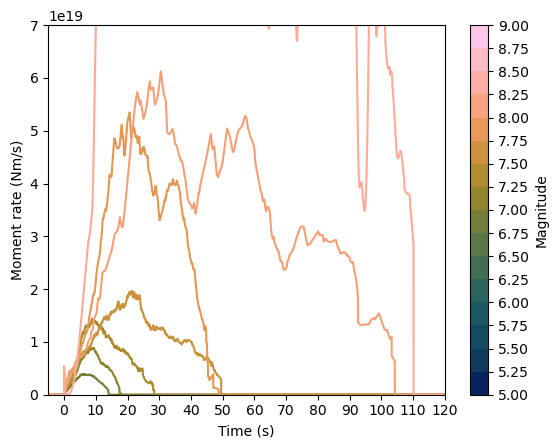

In [52]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all

fig, ax = plt.subplots()  # Create a figure and an axis
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if b < 7 or b > 8.5:
		continue
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		y_med = np.nanmedian(list(subset), axis = 0)
		x = np.arange(0, 20000, 1)
		y = np.zeros(21000)
		y[1000:] = y_med
		x = np.arange(-1000, 20000, 1)
		plt.plot(np.arange(-1000, 20000, 1), y, label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)

		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')
# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))

#plt.legend()

plt.xlim(-500, 12000)
plt.ylim(0, 7E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
#plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_datasets.png', bbox_inches = 'tight', dpi = 300)



7.0 0.0649 35
7.2 0.1012 22
7.5 0.1799 16
7.8 0.2074 12
8.0 0.3399 6
8.2 0.6899 4
8.5 0.0 0


/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc6/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


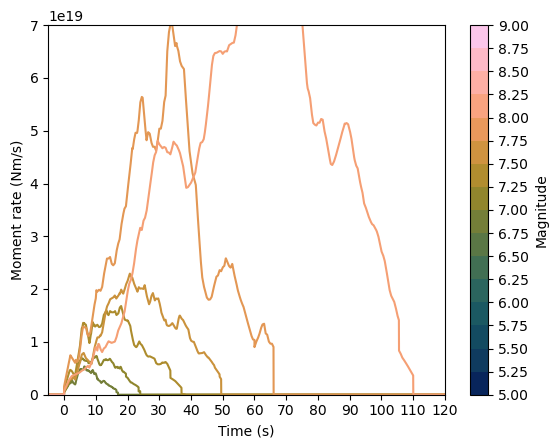

In [50]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all[df_interp_all['dataset'].str.contains('ye')]
fig, ax = plt.subplots()  # Create a figure and an axis
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if b < 7 or b > 8.5:
		continue
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		y_med = np.nanmedian(list(subset), axis = 0)
		x = np.arange(0, 20000, 1)
		y = np.zeros(21000)
		y[1000:] = y_med
		x = np.arange(-1000, 20000, 1)
		plt.plot(np.arange(-1000, 20000, 1), y, label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		#max_window = max(max_window, max(y_med[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ax=ax, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')
# all_data_on_plot = df_interp_ye[((df_interp_ye.mag > min(boundaries)))]
# all_data_on_plot = all_data_on_plot[all_data_on_plot.mag < max(boundaries)]

# print(len(all_data_on_plot), min(boundaries), max(boundaries))

# plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(all_data_on_plot.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))

#plt.legend()

plt.xlim(-500, 12000)
plt.ylim(0, 7E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
#plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017.png', bbox_inches = 'tight', dpi = 300)



7.0 0.0649 35
7.2 0.1012 22
7.5 0.1799 16
7.8 0.2074 12
8.0 0.3399 6
8.2 0.6899 4


/tmp/ipykernel_618767/717500328.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)


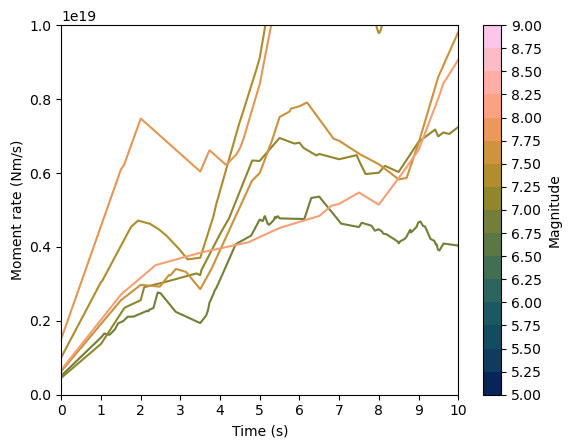

In [ ]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all[df_interp_all['dataset'].str.contains('ye')]
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if b < 7 or b > 8.5:
		continue
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), 
				 label = f'{b:.2f}---{b+interval:.2f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

#plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))

#plt.legend()

plt.xlim(-100, 1000)
plt.ylim(0, 1E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
#plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_zoom.png', bbox_inches = 'tight', dpi = 300)



7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3


/tmp/ipykernel_618767/856729439.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)


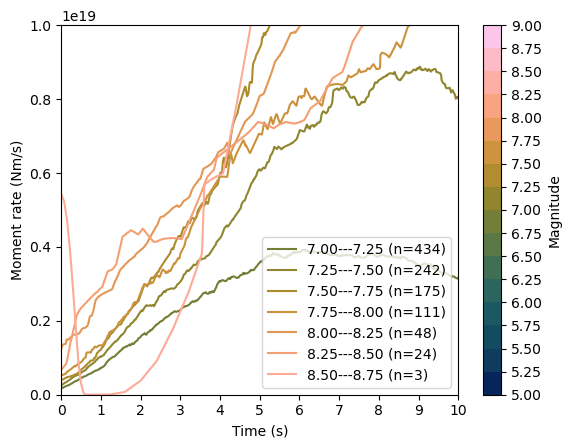

In [ ]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
max_window = 0
df_interp_ye = df_interp_all
for i, b in enumerate(boundaries):
	bigger_than = df_interp_ye[((df_interp_ye.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if b < 7 or b > 8.5:
		continue
	if len(subset) < 100:
		#continue
		marker = '-'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0), 
				 label = f'{b:.2f}---{b+interval:.2f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		max_window = max(max_window, max(np.nanmedian(list(subset), axis = 0)[0:1000]))
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

#plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 100), np.arange(0, 200, 1))

#plt.legend()

plt.xlim(0, 1000)
plt.ylim(0, 1E19)
# plt.ylim(0, max_window)
# plt.yscale('log')
#plt.legend()

plt.ylabel('Moment rate (Nm/s)')
plt.xlabel('Time (s)')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/recreate_meier_2017_all_datasets_zoom.png', bbox_inches = 'tight', dpi = 300)



5.0 0.0122 5
5.2 0.009 33
5.5 0.0205 204
5.8 0.0199 2977
6.0 0.0228 3029
6.2 0.0295 2129
6.5 0.0382 1227
6.8 0.0514 824
7.0 0.0613 434
7.2 0.0903 242
7.5 0.0879 175
7.8 0.2136 111
8.0 0.2069 48
8.2 0.3048 24
8.5 0.199 3
8.8 0.4702 3
9.0 0.6918 3


/tmp/ipykernel_618767/2895410563.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)


Text(0.5, 0, 'Normalised time')

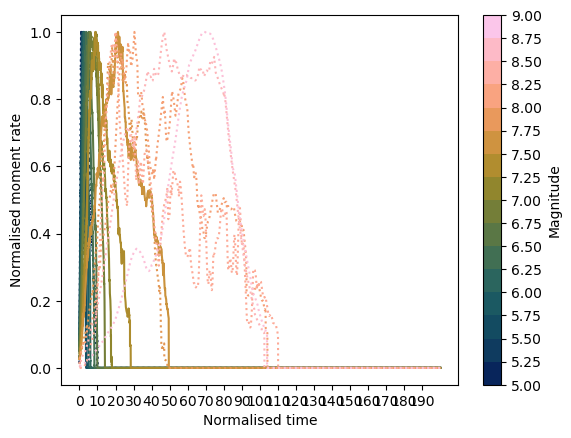

In [87]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

colors = cmc.batlow((np.linspace(0, len(boundaries), len(boundaries)+1)/len(boundaries)))
max_len = 0
peak_all = []
peak_more_than_100 = []
for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	if len(subset) < 100:
		marker = ':'
		alpha = 1
	else:
		marker = '-'
		alpha = 1
	# if np.isnan(np.nanmedian(list(subset), axis = 0))[0] == True:
	# 	continue
	try:
		plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(subset), axis = 0)/max(np.nanmedian(list(subset), axis = 0)), label = f'{b:.2f}---{b+interval:.1f} (n={len(subset)})', color = colors[i], linestyle = marker, alpha = alpha)
		print(np.round(b, 1), np.argmax(np.nanmedian(list(subset), axis = 0))/10000, len(subset))
		peak_all.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
		if len(subset) > 100:
			peak_more_than_100.append(np.argmax(np.nanmedian(list(subset), axis = 0))/10000)
	except ValueError:
		continue

sm = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=boundaries.min(), vmax=boundaries.max()))
cbar = plt.colorbar(sm, ticks=np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries)), boundaries=boundaries)
cbar.ax.set_yticklabels([f'{b:.2f}' for b in np.linspace(boundaries.min(), boundaries.max(), num=len(boundaries))])
cbar.set_label('Magnitude')

#plt.plot(np.arange(0, 20000, 1), np.nanmedian(list(df_interp.interp_momentrate.values), axis = 0), label = f'all events', color = 'k')


plt.xticks(np.arange(0, 20000, 1000), np.arange(0, 200, 10))



# plt.xlim(0, 1000)
# #plt.ylim(0, 1E19)
# plt.yscale('log')


plt.ylabel('Normalised moment rate')
plt.xlabel('Normalised time')
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_STF/median_only_every_025_nolegend_with_overall_median_non_norm.png', bbox_inches = 'tight', dpi = 300)



In [88]:
interval = 0.25
boundaries = np.arange(5, 9.1, interval)

print('Magnitude range & Number of events & Number of STFs \\\\ \hline')

for i, b in enumerate(boundaries):
	bigger_than = df_interp[((df_interp.mag > b))]
	filtered = bigger_than[bigger_than.mag < b+interval]
	max_len = max(max_len, len(filtered))
	subset = filtered.interp_momentrate.values
	print(f'{b:.2f}--{b+interval:.2f} & {filtered.event.nunique()} & {len(subset)} \\\\ \hline')

Magnitude range & Number of events & Number of STFs \\ \hline
5.00--5.25 & 5 & 5 \\ \hline
5.25--5.50 & 33 & 33 \\ \hline
5.50--5.75 & 115 & 204 \\ \hline
5.75--6.00 & 1506 & 2977 \\ \hline
6.00--6.25 & 1242 & 3029 \\ \hline
6.25--6.50 & 837 & 2129 \\ \hline
6.50--6.75 & 479 & 1227 \\ \hline
6.75--7.00 & 309 & 824 \\ \hline
7.00--7.25 & 158 & 434 \\ \hline
7.25--7.50 & 87 & 242 \\ \hline
7.50--7.75 & 57 & 175 \\ \hline
7.75--8.00 & 35 & 111 \\ \hline
8.00--8.25 & 15 & 48 \\ \hline
8.25--8.50 & 7 & 24 \\ \hline
8.50--8.75 & 1 & 3 \\ \hline
8.75--9.00 & 1 & 3 \\ \hline
9.00--9.25 & 1 & 3 \\ \hline
